In [ ]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.experimental import optimizers
from jax.ops import index_update, index

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [ ]:
def RNN(in_dim, out_dim, hidden_dim, num_lags):
    # Define init function
    def init(rng_key):
        # Define methods for initializing the weights
        def glorot_normal(rng_key, size):
          in_dim = size[0]
          out_dim = size[1]
          glorot_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
          return glorot_stddev*random.normal(rng_key, (in_dim, out_dim))
        # Inputs
        U = glorot_normal(rng_key, (in_dim, hidden_dim))
        b = np.zeros(hidden_dim)
        # Transition dynamics
        W = np.eye(hidden_dim)
        # Outputs
        V = glorot_normal(rng_key, (hidden_dim, out_dim))
        c = np.zeros(out_dim)
        return (U, b, W, V, c)
    # Define apply function
    def apply(params, input):
        U, b, W, V, c = params
        H = np.zeros((input.shape[1], hidden_dim))
        for i in range(num_lags):
            H = np.tanh(np.matmul(H, W) + np.matmul(input[i,:,:], U) + b)       
        H = np.matmul(H, V) + c
        return H
    return init, apply


In [ ]:
def create_lags(data, L):
    N = data.shape[0] - L
    D = data.shape[1]
    X = np.zeros((L, N, D))
    Y = np.zeros((N, D))
    for i in range(0,N):
        X = index_update(X, index[:,i,:], data[i:(i+L), :])
        Y = index_update(Y, index[i,:], data[i+L, :])
    return X, Y

In [ ]:
class Seq2seq():
  def __init__(self, dataset, num_lags, hidden_dim, rng_key = random.PRNGKey(0)):
    # Normalize across data-points dimension
    self.mean, self.std = dataset.mean(0), dataset.std(0)
    dataset = (dataset - self.mean)/self.std

    # Create the lagged normalized trainind data
    # X: L x N x D
    # Y: N x D
    self.X, self.Y = create_lags(dataset, num_lags)
    in_dim = self.X.shape[-1]
    out_dim = self.Y.shape[-1]

    # Initialization and evaluation functions
    self.net_init, self.net_apply = RNN(in_dim, out_dim, hidden_dim, num_lags)
    
    # Initialize parameters, not committing to a batch shape
    self.net_params = self.net_init(rng_key)
                
    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(1e-3)
    self.opt_state = self.opt_init(self.net_params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

  def loss(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss = np.mean((y - y_pred)**2)
    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[:, batch_idx, :], self.Y[batch_idx, :]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[1]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      self.net_params = self.get_params(self.opt_state)
      loss_value = self.loss(self.net_params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  @partial(jit, static_argnums=(0,))
  def predict(self, params, inputs):
    Y_pred = self.net_apply(params, inputs)
    return Y_pred

In [ ]:
def f(t):
    f = np.sin(np.pi*t)
    return f

In [ ]:
rng_key = random.PRNGKey(0)
noise = 0.0

t = np.arange(0,10,0.1)[:,None]
dataset = f(t)
dataset = dataset + dataset.std(0)*noise*random.normal(rng_key, dataset.shape)

# Use 2/3 of all data as training Data
train_size = int(len(dataset) * (2.0/3.0))
train_data = dataset[0:train_size,:]

In [ ]:
print(dataset.shape)

(100, 1)


In [ ]:
# Model creation
num_lags = 5
hidden_dim = 4
model = Seq2seq(train_data, num_lags, hidden_dim, rng_key)

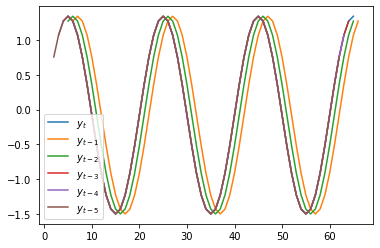

In [ ]:
N = model.Y.shape[0]
plt.figure()
plt.plot(np.arange(num_lags, N+num_lags), model.Y, label = '$y_t$')
for i in range(num_lags):
  plt.plot(np.arange(num_lags-i+1, N+num_lags-i+1), model.X[num_lags-i+1,:,:], label = '$y_{t-%d}$' % (i+1))
plt.legend()

In [ ]:
model.train(num_epochs = 10000, batch_size = 128)

100%|██████████| 10000/10000 [05:31<00:00, 30.20it/s, Loss=3.856435e-06]


In [ ]:
opt_params = model.net_params
# One-step ahead prediction (normalized)
N, D = dataset.shape
pred = np.zeros((N-num_lags, D))
X_tmp =  model.X[:,0:1,:]
for i in trange(N-num_lags):
    pred = index_update(pred, index[i:i+1], model.net_apply(opt_params, X_tmp))
    X_tmp = index_update(X_tmp, index[:-1,:,:], X_tmp[1:,:,:])
    X_tmp = index_update(X_tmp, index[-1,:,:], pred[i])
# De-normalize predictions
pred = pred*model.std + model.mean
error = np.linalg.norm(dataset[num_lags:] - pred, 2)/np.linalg.norm(dataset[num_lags:], 2)
print('Relative L2 prediction error: %e' % (error))

100%|██████████| 95/95 [00:03<00:00, 25.46it/s]


Relative L2 prediction error: 1.771053e-03


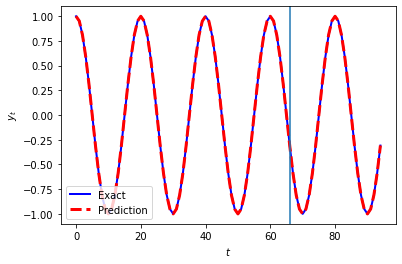

In [ ]:
plt.figure(1)
plt.plot(dataset[num_lags:], 'b-', linewidth = 2, label = "Exact")
plt.plot(pred, 'r--', linewidth = 3, label = "Prediction")
# plt.plot(X.shape[1]*np.ones((2,1)), np.linspace(-1.75,1.75,2), 'k--', linewidth=2)
plt.axvline(train_size)
plt.axis('tight')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc='lower left')